# 单层注意力分析

绘制两张图：
1. **2D 热力图**: Query Frame × Key Frame，3×4 网格显示 12 个 head
2. **Per-Head Grid**: 最后一个 block 对各帧的注意力柱状图

In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch

# plt.rcParams.update({
#     "font.size": 11,
#     "figure.dpi": 300,
#     "savefig.dpi": 300,
#     "savefig.bbox": "tight",
# })
plt.rcParams.update(
    {
        "svg.fonttype": "none",
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
    }
)

## 配置

In [2]:
# ============================================================
# 配置
# ============================================================

DATA_PATH = "../cache/layer3.pt"
SAVE_DIR = "attention_analysis/layer3"
SAVE_SVG = True

## 加载数据

In [3]:
data = torch.load(DATA_PATH, map_location="cpu", weights_only=False)

print("=" * 60)
print(f"Layer: {data['layer_index']}")
print(f"Prompt: {data.get('prompt', 'N/A')}")
print(f"Num frames: {data.get('num_frames', 'N/A')}")
print(f"Num heads: {data.get('num_heads', 'N/A')}")
print(f"Block sizes: {data.get('block_sizes', 'N/A')}")
print(f"Last block Q frames: {data.get('last_block_query_frames', 'N/A')}")

# 加载数据
layer_idx = data['layer_index']
num_frames = data['num_frames']
num_heads = data['num_heads']

# 完整的 frame×frame 注意力矩阵
full_frame_attn = data['full_frame_attention'].float().numpy()  # [num_heads, Q, K]
print(f"\nFull attention shape: {full_frame_attn.shape}")
print(f"Range: [{full_frame_attn.min():.4f}, {full_frame_attn.max():.4f}]")

# 最后一个 block 的帧注意力（用于柱状图）
last_block_attn = data['last_block_frame_attention'].float().numpy()  # [num_heads, K]
last_block_q_frames = data.get('last_block_query_frames', [18, 19, 20])
print(f"\nLast block attention shape: {last_block_attn.shape}")

Layer: 3
Prompt: A majestic eagle soaring through a cloudy sky, cinematic lighting
Num frames: 21
Num heads: 12
Block sizes: [3, 3, 3, 3, 3, 3, 3]
Last block Q frames: [18, 19, 20]

Full attention shape: (12, 21, 21)
Range: [-14.1328, 14.0469]

Last block attention shape: (12, 21)


## 图1: 2D 热力图 (Query Frame × Key Frame)

/tmp/ipykernel_7493/3468331261.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 0.98])


Saved: attention_analysis/layer3/layer3_2d_heatmap_all_heads.svg


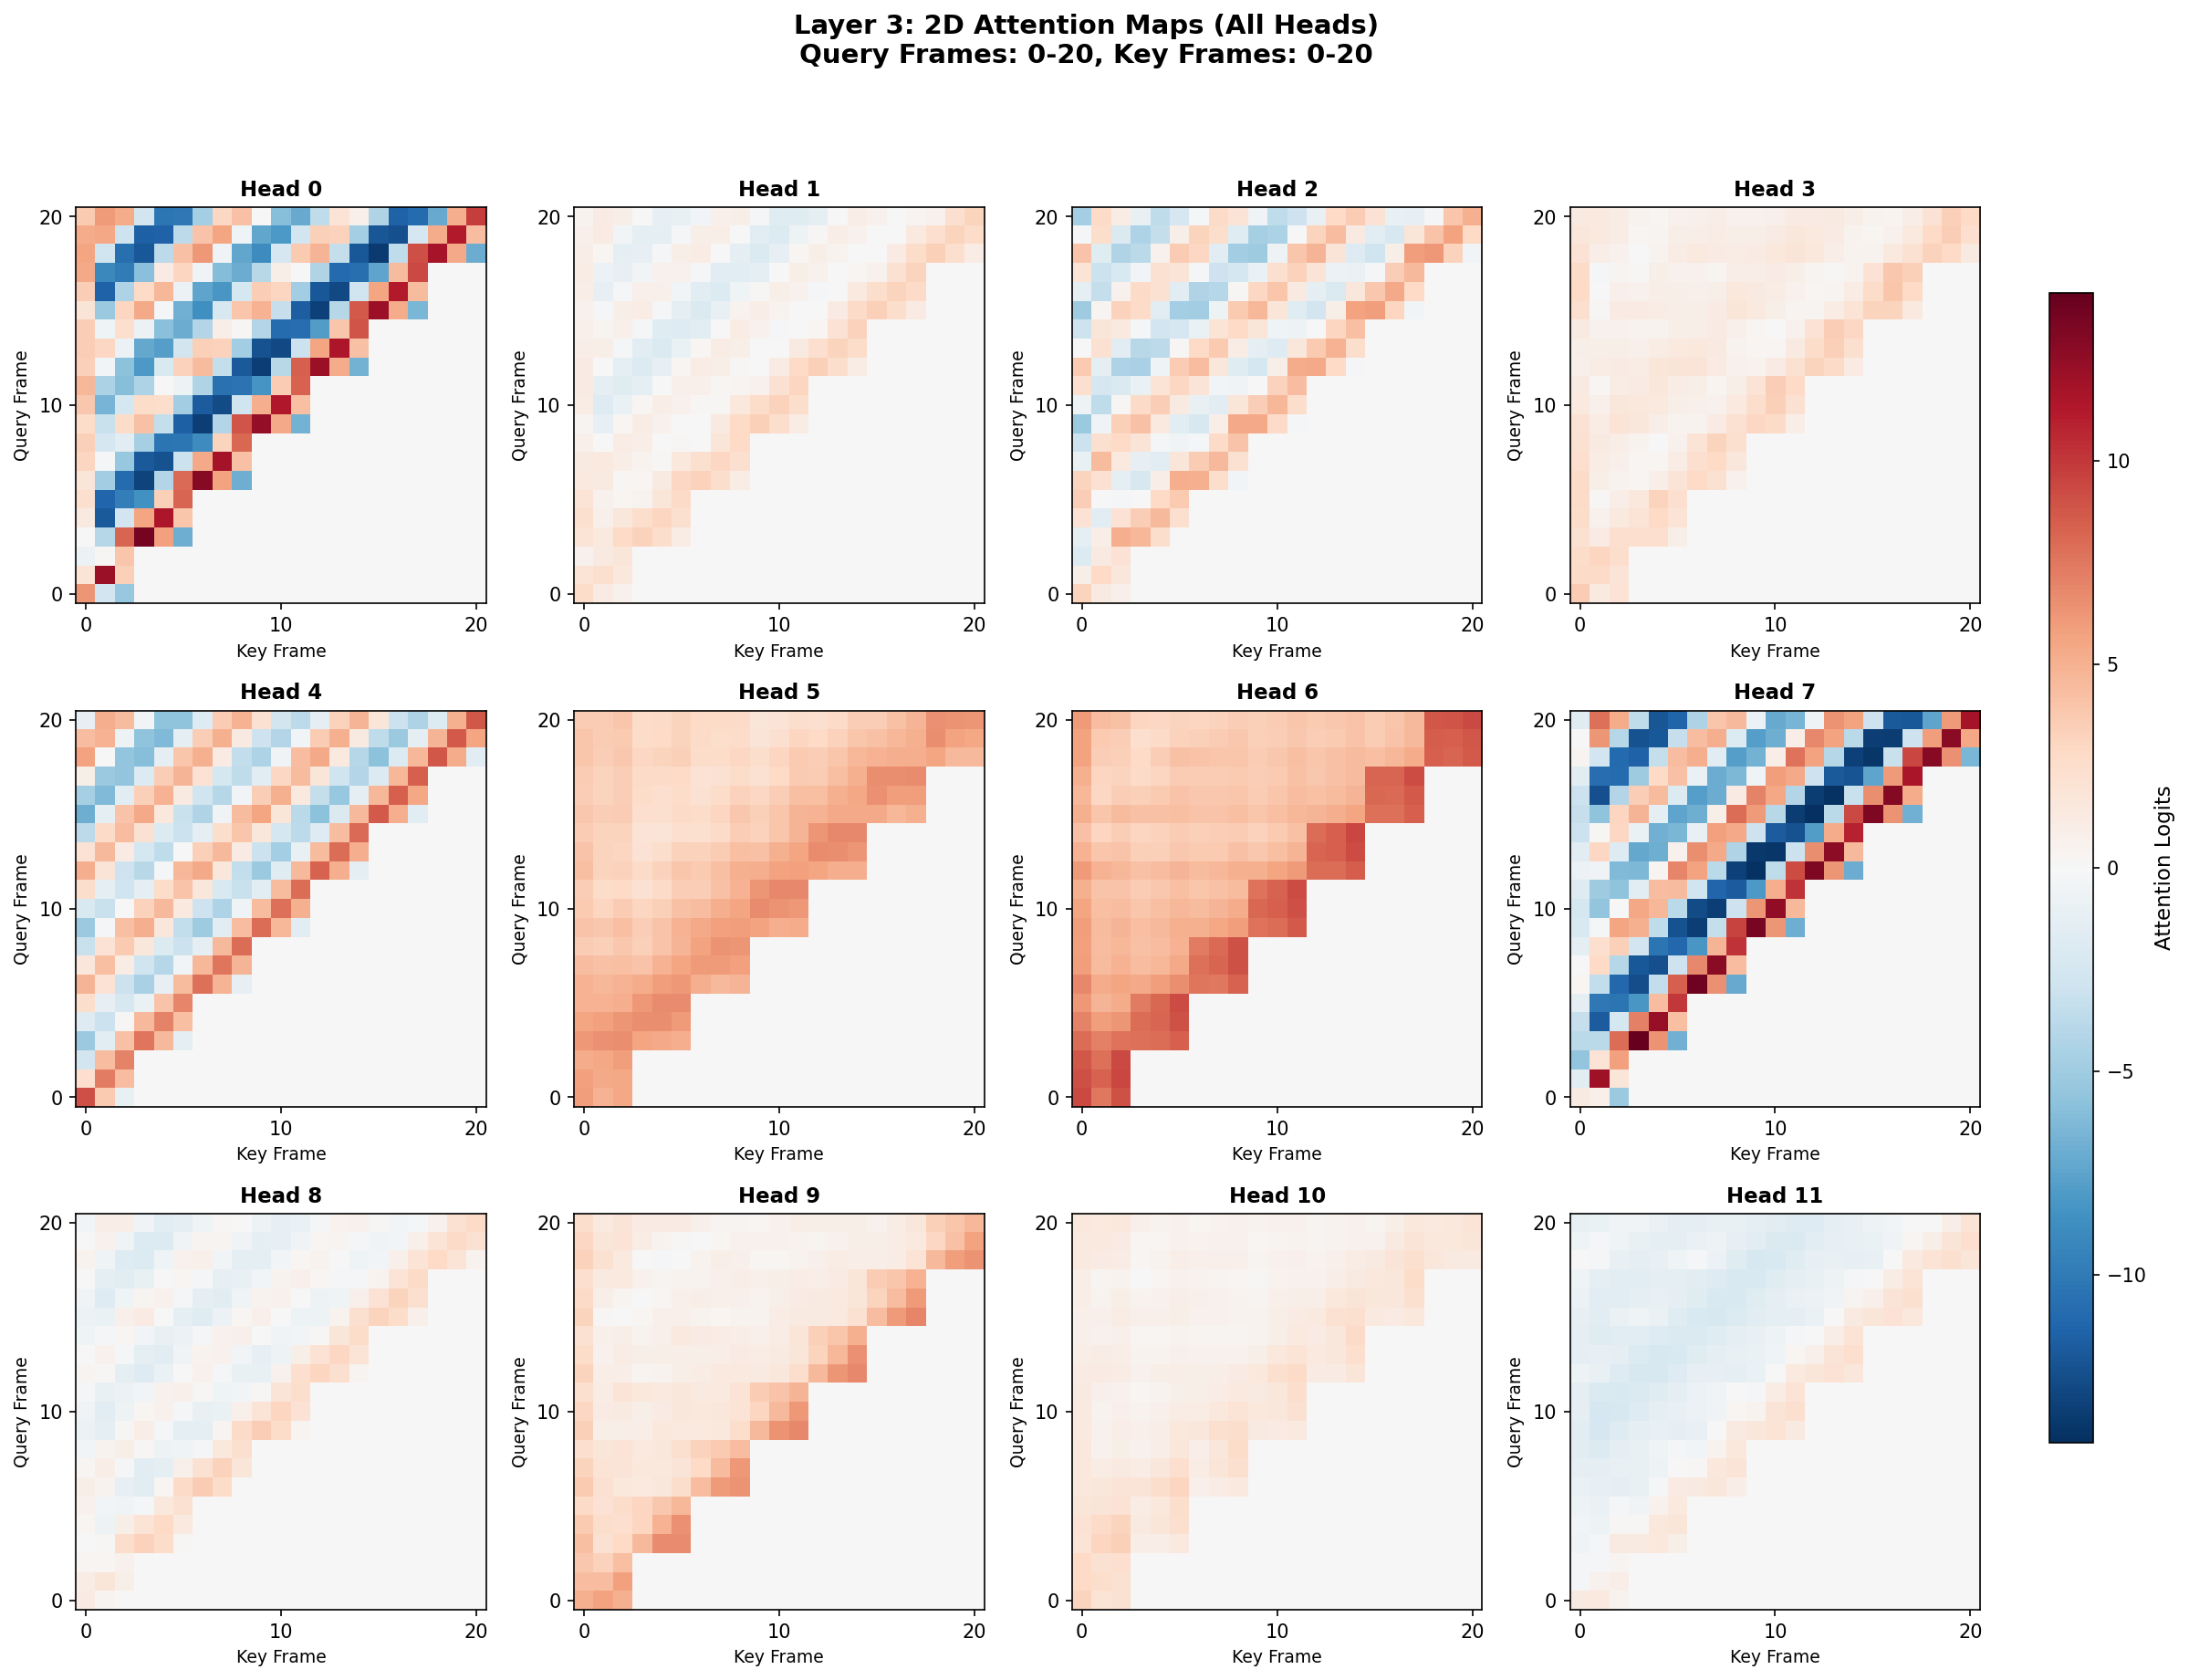

In [4]:
# ============================================================
# 图1: 2D 热力图 - 每个 head 一张小图
# X-axis: Key Frame Index (0-20)
# Y-axis: Query Frame Index (0-20)
# Layout: 3×4 grid for 12 heads
# ============================================================

ncols = 4
nrows = math.ceil(num_heads / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 12))
axes = axes.flatten()

# 全局 colorbar 范围（对称，便于 RdBu_r 显示）
vmax = max(abs(full_frame_attn.min()), abs(full_frame_attn.max()))
vmin = -vmax

for h in range(num_heads):
    ax = axes[h]
    attn_map = full_frame_attn[h]  # [Q, K]
    
    im = ax.imshow(
        attn_map,
        cmap="RdBu_r",
        aspect="auto",
        origin="lower",
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest"
    )
    
    ax.set_title(f"Head {h}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Key Frame", fontsize=9)
    ax.set_ylabel("Query Frame", fontsize=9)
    
    # 设置刻度
    tick_pos = [0, num_frames // 2, num_frames - 1]
    ax.set_xticks(tick_pos)
    ax.set_xticklabels(tick_pos)
    ax.set_yticks(tick_pos)
    ax.set_yticklabels(tick_pos)

# 隐藏多余的子图
for k in range(num_heads, len(axes)):
    axes[k].axis("off")

# 添加 colorbar
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label("Attention Logits", fontsize=11)

fig.suptitle(
    f"Layer {layer_idx}: 2D Attention Maps (All Heads)\n"
    f"Query Frames: 0-{num_frames-1}, Key Frames: 0-{num_frames-1}",
    fontsize=14,
    fontweight="bold",
    y=1.02
)

plt.tight_layout(rect=[0, 0, 0.92, 0.98])

if SAVE_SVG:
    os.makedirs(SAVE_DIR, exist_ok=True)
    save_path = os.path.join(SAVE_DIR, f"layer{layer_idx}_2d_heatmap_all_heads.svg")
    plt.savefig(save_path, format="svg", bbox_inches="tight")
    print(f"Saved: {save_path}")

plt.show()

## 图2: Per-Head Grid (最后一个 block 对各帧的注意力)

Saved: attention_analysis/layer3/layer3_perhead_grid.svg


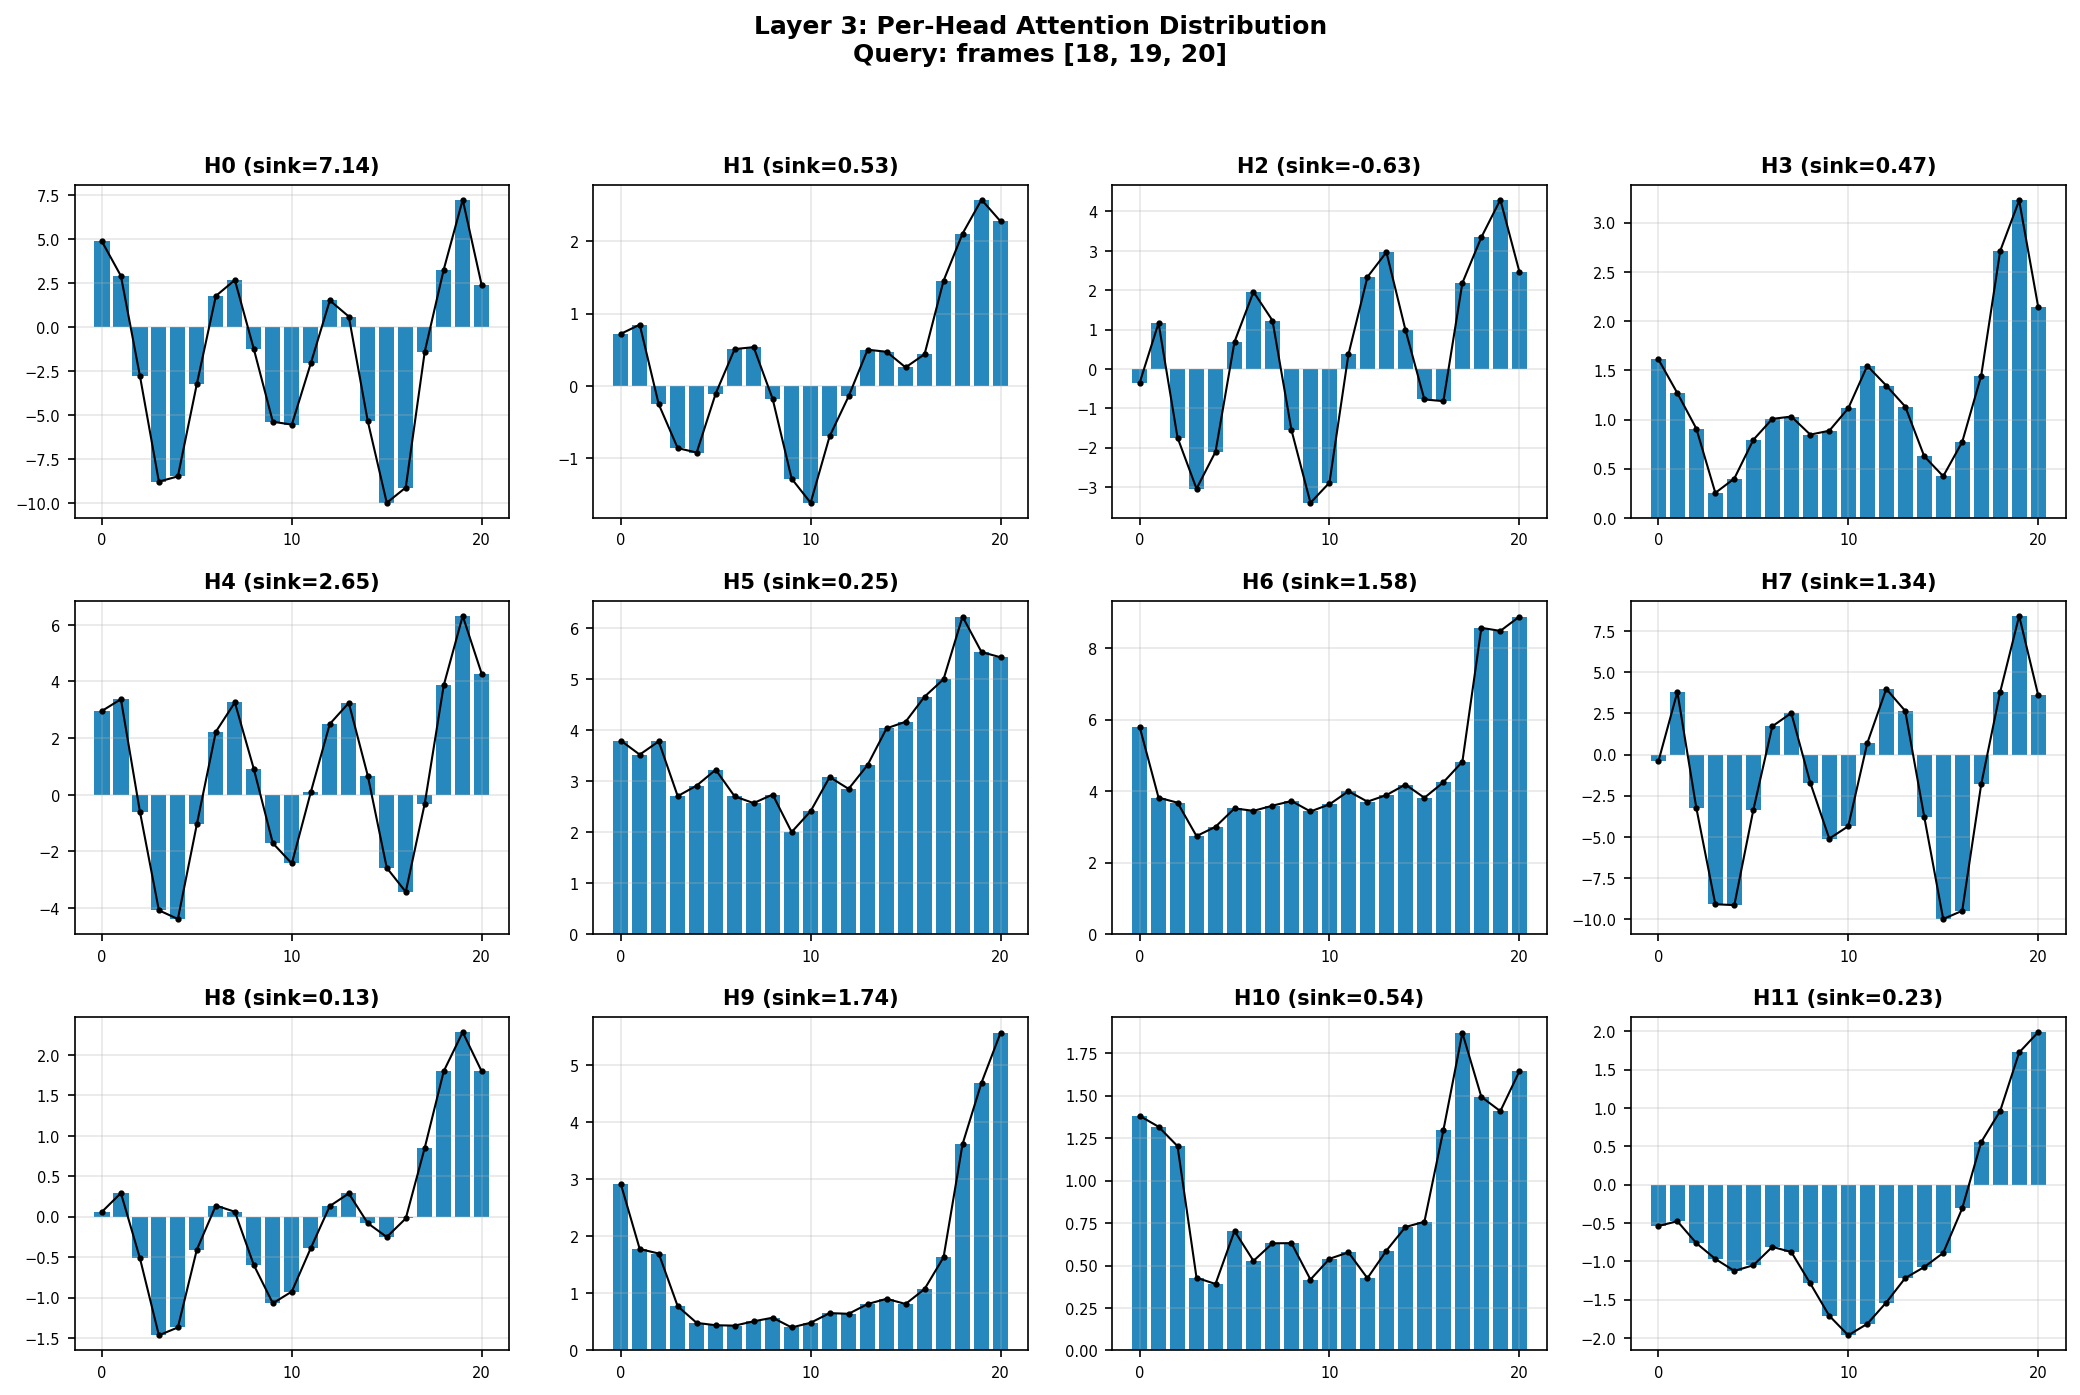

In [8]:
# ============================================================
# 图2: Per-Head Grid 柱状图
# 显示最后一个 block (frames 18-20) 对各 key frame 的注意力
# ============================================================

key_indices = np.arange(num_frames)

ncols = 4
nrows = math.ceil(num_heads / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows))
axes = axes.flatten()

BAR_COLOR = sns.color_palette("colorblind")[0]

for h in range(num_heads):
    ax = axes[h]
    head = last_block_attn[h]  # [K]
    
    # 计算 sink score (首帧 - 中间帧均值)
    first = head[0]
    middle = head[1:-1].mean() if len(head) > 2 else head.mean()
    sink_score = first - middle
    
    ax.bar(key_indices, head, alpha=0.85, width=0.8, color=BAR_COLOR)
    ax.plot(key_indices, head, "o-", color="black", linewidth=1, markersize=2)
    ax.set_title(f"H{h} (sink={sink_score:.2f})", fontsize=10, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=7)
    ax.grid(True, alpha=0.3)
    
    if len(key_indices) > 10:
        ax.set_xticks([0, len(key_indices) // 2, len(key_indices) - 1])

for k in range(num_heads, len(axes)):
    axes[k].axis("off")

fig.suptitle(
    f"Layer {layer_idx}: Per-Head Attention Distribution\n"
    f"Query: frames {last_block_q_frames}",
    fontsize=12,
    fontweight="bold",
    y=1.00 + (0.01 * nrows),
)

plt.tight_layout()

if SAVE_SVG:
    os.makedirs(SAVE_DIR, exist_ok=True)
    save_path = os.path.join(SAVE_DIR, f"layer{layer_idx}_perhead_grid.svg")
    plt.savefig(save_path, format="svg", bbox_inches="tight")
    print(f"Saved: {save_path}")

plt.show()

## 统计

In [6]:
print("=" * 60)
print(f"Layer {layer_idx} Statistics")
print("=" * 60)

# 全局统计
diag = np.array([full_frame_attn[h, i, i] for h in range(num_heads) for i in range(num_frames)])
diag_mean = diag.mean()
first_col = full_frame_attn[:, :, 0]
first_col_mean = first_col[first_col != 0].mean() if (first_col != 0).any() else 0

print(f"Diagonal mean (self-attention): {diag_mean:.4f}")
print(f"First frame mean (sink): {first_col_mean:.4f}")

print("\nPer-Head Statistics (last block):")
for h in range(num_heads):
    head = last_block_attn[h]
    first = head[0]
    middle = head[1:-1].mean() if len(head) > 2 else head.mean()
    last = head[-1]
    sink = first - middle
    
    print(f"  H{h:2d}: first={first:7.3f}, mid={middle:7.3f}, last={last:7.3f}, sink={sink:+7.3f}")

Layer 3 Statistics
Diagonal mean (self-attention): 5.4708
First frame mean (sink): 1.6050

Per-Head Statistics (last block):
  H 0: first=  4.863, mid= -2.279, last=  2.371, sink= +7.142
  H 1: first=  0.718, mid=  0.190, last=  2.275, sink= +0.528
  H 2: first= -0.360, mid=  0.274, last=  2.473, sink= -0.634
  H 3: first=  1.612, mid=  1.144, last=  2.146, sink= +0.468
  H 4: first=  2.959, mid=  0.310, last=  4.270, sink= +2.649
  H 5: first=  3.799, mid=  3.552, last=  5.434, sink= +0.247
  H 6: first=  5.805, mid=  4.224, last=  8.875, sink= +1.580
  H 7: first= -0.422, mid= -1.763, last=  3.611, sink= +1.342
  H 8: first=  0.061, mid= -0.065, last=  1.796, sink= +0.126
  H 9: first=  2.920, mid=  1.180, last=  5.562, sink= +1.740
  H10: first=  1.382, mid=  0.839, last=  1.644, sink= +0.543
  H11: first= -0.541, mid= -0.771, last=  1.987, sink= +0.231


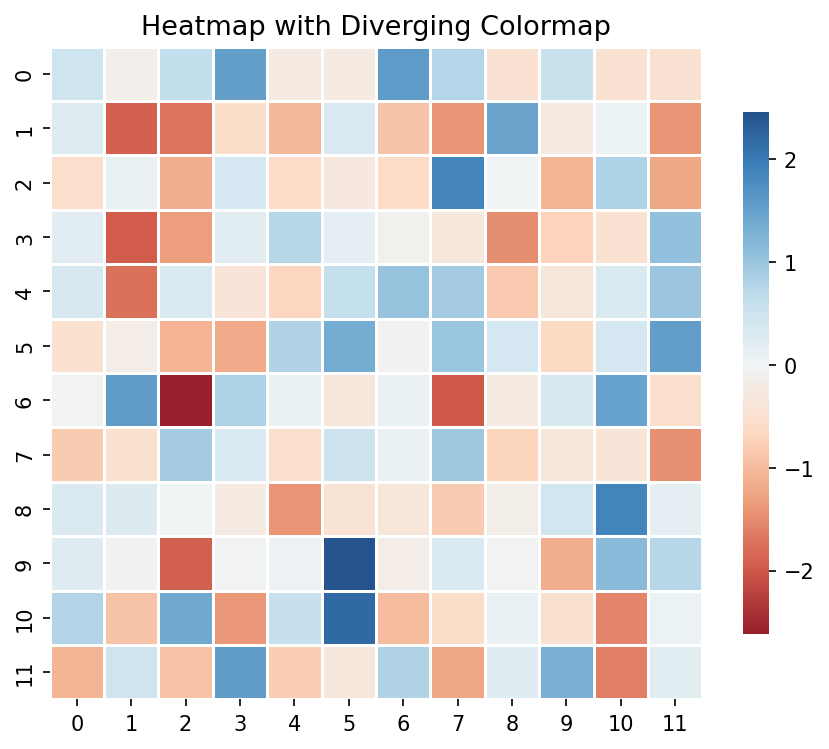

In [7]:
# ===== Jupyter Notebook Heatmap Demo =====

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# 1. 构造示例数据（包含正负值，适合 diverging colormap）
np.random.seed(42)
data = np.random.randn(12, 12)

# 2. 主题选择（三选一）
# ==================================================

# ✅ 方案一（当前启用）：Seaborn icefire（推荐，最接近你的 Hex）
# cmap = sns.color_palette("icefire", as_cmap=True)

# ⛔ 方案二：Seaborn vlag（更冷、更现代）
# cmap = sns.color_palette("RdBu_r", as_cmap=True)

# ⛔ 方案三：你自定义的 Hex 颜色热力图
hex_colors = [
    "#98202C", "#D15C4C", "#EEA17E", "#FDDAC3",
    "#F0F4F5",  # 中间过渡色
    "#C2DEEC", "#79B0D4", "#3C7FB9", "#1D4680"
]
cmap = mcolors.LinearSegmentedColormap.from_list(
    "user_heatmap", hex_colors
)

# 3. 绘制热力图
plt.figure(figsize=(6, 5))
sns.heatmap(
    data,
    cmap=cmap,
    center=0,          # 关键：以 0 为中心
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Heatmap with Diverging Colormap", fontsize=13)
plt.tight_layout()
plt.show()
